In [46]:
import numpy as np 
import SC_search
import matplotlib.pyplot as plt
import scienceplots 
import matplotlib
import itertools
matplotlib.rcParams.update({'font.size': 22})
plt.style.use('science')


In [9]:
# Frequency domain setup
year_in_seconds = 365.25*24*60*60

# Frequency bounds
f_low = 0.018
f_high = 0.03



T_obs = (3*year_in_seconds)
d = 1/(T_obs)
safety = 10
cadence = 2/(f_high*safety)

freqs = np.arange(0.015,f_high+d,d)


In [10]:
Sdisp = SC_search.Noise.Sdisp_SciRD(freqs)
Sopt = SC_search.Noise.Sopt_SciRD(freqs)
psd_A = SC_search.Noise.psd_AEX(freqs,Sdisp,Sopt)
psd_E = SC_search.Noise.psd_AEX(freqs,Sdisp,Sopt)
psd_T = SC_search.Noise.psd_TX(freqs,Sdisp,Sopt)

global psd_array
psd_array = np.array([psd_A,psd_E,psd_T])

In [22]:
source_parameters = np.array([28.09555579546043,#mc [sm]
                    0.24710059171597634,#eta
                    50.1*(1.e+6),#D
                    np.pi/4,#beta [rads]
                    2.01,#lambda [rads]
                    2.498091544796509,#inc [rads]
                    -1.851592653589793,#polarization [rads]
                    0,#phi0 [rads]
                    0.018/2,
                    0.01])#e0

finite_differences = np.array([0.0001,#mc
                      0.00001,#eta
                      0,#D       
                      0.0001,#beta
                      0.001,#lambda
                      0.,#inc
                      0.,#pol
                      0.,#phi0
                      1e-9,#f_low # Might need to be lower
                      1e-4])#e0

phasing_param_indexes = np.array([0,#mc
                         1,#eta,#
                         3,#beta
                         4,#lambda
                         # 5,#inc
                         # 6,#pol
                         8,#f_low
                         9])#e0





In [23]:
source_params_transformed = SC_search.Utility.TaylorF2Ecc_mc_eta_to_m1m2(source_parameters.copy())
# Use interpolation functionality from BBHx
freqs_sparse = freqs[::1000]
injection_signal= SC_search.Waveforms.TaylorF2Ecc.BBHx_response_interpolate_CPU(source_params_transformed,
                                                                                  freqs_sparse,
                                                                                  freqs,
                                                                                  f_high,
                                                                                  T_obs,
                                                                                  'AET',
                                                                                  logging=True)


Time to merger is:  3.5550937742535975  years
Upper bound on time in band:  2.6438861012726447  years (no eccentricity evolution assumed)


In [13]:
def waveform_generation(parameters):
    '''
    Generate a waveform 
    '''
    params_transformed = SC_search.Utility.TaylorF2Ecc_mc_eta_to_m1m2(parameters.copy())
    wf = SC_search.Waveforms.TaylorF2Ecc.BBHx_response_interpolate_CPU(params_transformed,
                                                                                  freqs_sparse,
                                                                                  freqs,
                                                                                  f_high,
                                                                                  T_obs,
                                                                                  'AET',
                                                                                  logging=False)
    return(wf)
    
def second_derivative(params,indexes,num_segments):
    '''
    Compute numerical derivatives of the waveforms for computation of the metric on the parameter space wrt the semi-coherent match 
    '''

    # If g_ii term
    
    if indexes[0] == indexes[1]:

        forward = params.copy()
        backward = params.copy()
        
        forward[indexes[0]] += finite_differences.copy()[indexes[0]]
        backward[indexes[0]] -= finite_differences.copy()[indexes[0]]
        
        forward_term = SC_search.Semi_Coherent_Functions.semi_coherent_match(waveform_generation(forward.copy()),
                                                                             waveform_generation(params.copy()),
                                                                              psd_array,d,num_segments=num_segments)
                        
        backward_term = SC_search.Semi_Coherent_Functions.semi_coherent_match(waveform_generation(backward.copy()),
                                                                              waveform_generation(params.copy()),
                                                                              psd_array,d,num_segments=num_segments)
                         
        central_term = SC_search.Semi_Coherent_Functions.semi_coherent_match(waveform_generation(params.copy()),
                                                                                  waveform_generation(params.copy()),
                                                                                  psd_array,d,num_segments=num_segments)  
        
        
        der = (forward_term+backward_term-2*central_term)/np.abs(finite_differences.copy()[indexes[0]])**2
        
    else:
    # If g_ij
        forward_i_j = params.copy()
        backward_i_j = params.copy()
        forward_i = params.copy()
        forward_j = params.copy()
        backward_i = params.copy()
        backward_j = params.copy()


        
        forward_i_j[indexes] += finite_differences.copy()[indexes]
        backward_i_j[indexes] -= finite_differences.copy()[indexes]

        forward_i[indexes[0]] += finite_differences.copy()[indexes[0]]
        forward_j[indexes[1]] += finite_differences.copy()[indexes[1]]

        backward_i[indexes[0]] -= finite_differences.copy()[indexes[0]]
        backward_j[indexes[1]] -= finite_differences.copy()[indexes[1]]

        forward_ij_term = SC_search.Semi_Coherent_Functions.semi_coherent_match(waveform_generation(forward_i_j.copy()),
                                                                                  waveform_generation(params.copy()),                                                                                  
                                                                                  psd_array,d,num_segments=num_segments)
                           
        backward_ij_term = SC_search.Semi_Coherent_Functions.semi_coherent_match(waveform_generation(backward_i_j.copy()),
                                                                                  waveform_generation(params.copy()), 
                                                                                  psd_array,d,num_segments=num_segments)

        forward_i_term = SC_search.Semi_Coherent_Functions.semi_coherent_match(waveform_generation(forward_i.copy()),
                                                                                  waveform_generation(params.copy()),
                                                                                  psd_array,d,num_segments=num_segments)                            

        forward_j_term = SC_search.Semi_Coherent_Functions.semi_coherent_match(waveform_generation(forward_j.copy()),
                                                                                  waveform_generation(params.copy()),
                                                                                  psd_array,d,num_segments=num_segments)     
                          
        backward_i_term = SC_search.Semi_Coherent_Functions.semi_coherent_match(waveform_generation(backward_i.copy()),
                                                                                  waveform_generation(params.copy()),
                                                                                  psd_array,d,num_segments=num_segments)                            

        backward_j_term = SC_search.Semi_Coherent_Functions.semi_coherent_match(waveform_generation(backward_j.copy()),
                                                                                  waveform_generation(params.copy()),
                                                                                  psd_array,d,num_segments=num_segments)                            
        
        central_term = SC_search.Semi_Coherent_Functions.semi_coherent_match(waveform_generation(params.copy()),
                                                                                  waveform_generation(params.copy()),
                                                                                  psd_array,d,num_segments=num_segments)  
        
        der = 1/(2*finite_differences.copy()[indexes[0]]*finite_differences.copy()[indexes[1]])*(forward_ij_term
                                                                                                 -forward_i_term
                                                                                                 -forward_j_term
                                                                                                 +2*central_term
                                                                                                 -backward_i_term
                                                                                                 -backward_j_term
                                                                                                 +backward_ij_term)
        
    return(der)
    
def generate_metric(params,num_segments):
    '''
    Generate metric over all the phasing parameter. Put zeros in the spots for the other parameters.
    '''

    # Empty metric array
    g_ij = np.zeros((params.size,params.size))
    
    for i in phasing_param_indexes:
        for j in phasing_param_indexes:
            index_pairs = (i,j)
            g_ij[index_pairs] = -1/2*second_derivative(params.copy(),np.array(index_pairs),num_segments)
    
    return(g_ij)

def subset_metric(g_ij_whole):
    '''
    Postprocess the metric down to just the phasing parameters. 
    '''
    
    g_ij_subset = np.zeros((phasing_param_indexes.size,phasing_param_indexes.size))
    
    for subset_index_i,i in enumerate(phasing_param_indexes):
        for subset_index_j,j in enumerate(phasing_param_indexes):
            g_ij_subset[subset_index_i,subset_index_j] = g_ij_whole[i,j]
            
    return(g_ij_subset)

In [24]:
# Compute metrics at a number of segments around the injection point
g_1 = subset_metric(generate_metric(source_parameters,1))
g_10 = subset_metric(generate_metric(source_parameters,10))
g_100 = subset_metric(generate_metric(source_parameters,100))
g_1000 = subset_metric(generate_metric(source_parameters,1000))

In [17]:
SNR_squared = 4*np.real(np.sum(injection_signal*injection_signal.conj()/psd_array*d))
SNR = np.sqrt(SNR_squared)
SNR

38.031644871668014

In [25]:
# Width of peak in every dimension, ignoring covariances 
print(np.sqrt(np.diag(np.linalg.inv(g_1)/(2*SNR**2))))
print(np.sqrt(np.diag(np.linalg.inv(g_10)/(2*SNR**2))))
print(np.sqrt(np.diag(np.linalg.inv(g_100)/(2*SNR**2))))
print(np.sqrt(np.diag(np.linalg.inv(g_1000)/(2*SNR**2))))

[4.59087175e-06 1.02309155e-04 8.53194062e-04 1.15655239e-03
 1.41632871e-10 3.53465131e-06]
[1.42118868e-05 1.28085333e-03 1.62888515e-03 1.98294652e-03
 1.03681702e-09 3.60225566e-06]
[1.52073590e-03 1.10116345e-01 1.18780614e-02 1.57856452e-02
 1.18266792e-08 6.76907140e-05]
[1.77050363e-01 1.09668567e+01 2.90643419e-02 3.68555140e-02
 2.14357896e-07 1.38999689e-02]


In [26]:
#Mc,beta,lambda,f_low,e0

Keeping in mind this is sort of a lower limit to the width at each segment, I think.

In [27]:
widths_1 = np.sqrt(np.diag(np.linalg.inv(g_1)/(2*SNR**2)))
widths_10 = np.sqrt(np.diag(np.linalg.inv(g_10)/(2*SNR**2)))
widths_100 = np.sqrt(np.diag(np.linalg.inv(g_100)/(2*SNR**2)))
widths_1000 = np.sqrt(np.diag(np.linalg.inv(g_1000)/(2*SNR**2)))
N = [1,10,100,1000]

In [32]:
labels = [r'$\sigma(\mathcal{M}_c) \, [\mathrm{M}_{\odot}]$',
         r'$\sigma(\eta)$',
         r'$\sigma(\beta) \, [\mathrm{rads}]$',
         r'$\sigma(\lambda)  \, [\mathrm{rads}]$',
         r'$\sigma(f_0) \, [\mathrm{Hz}]$',
         r'$\sigma(e_0)$']

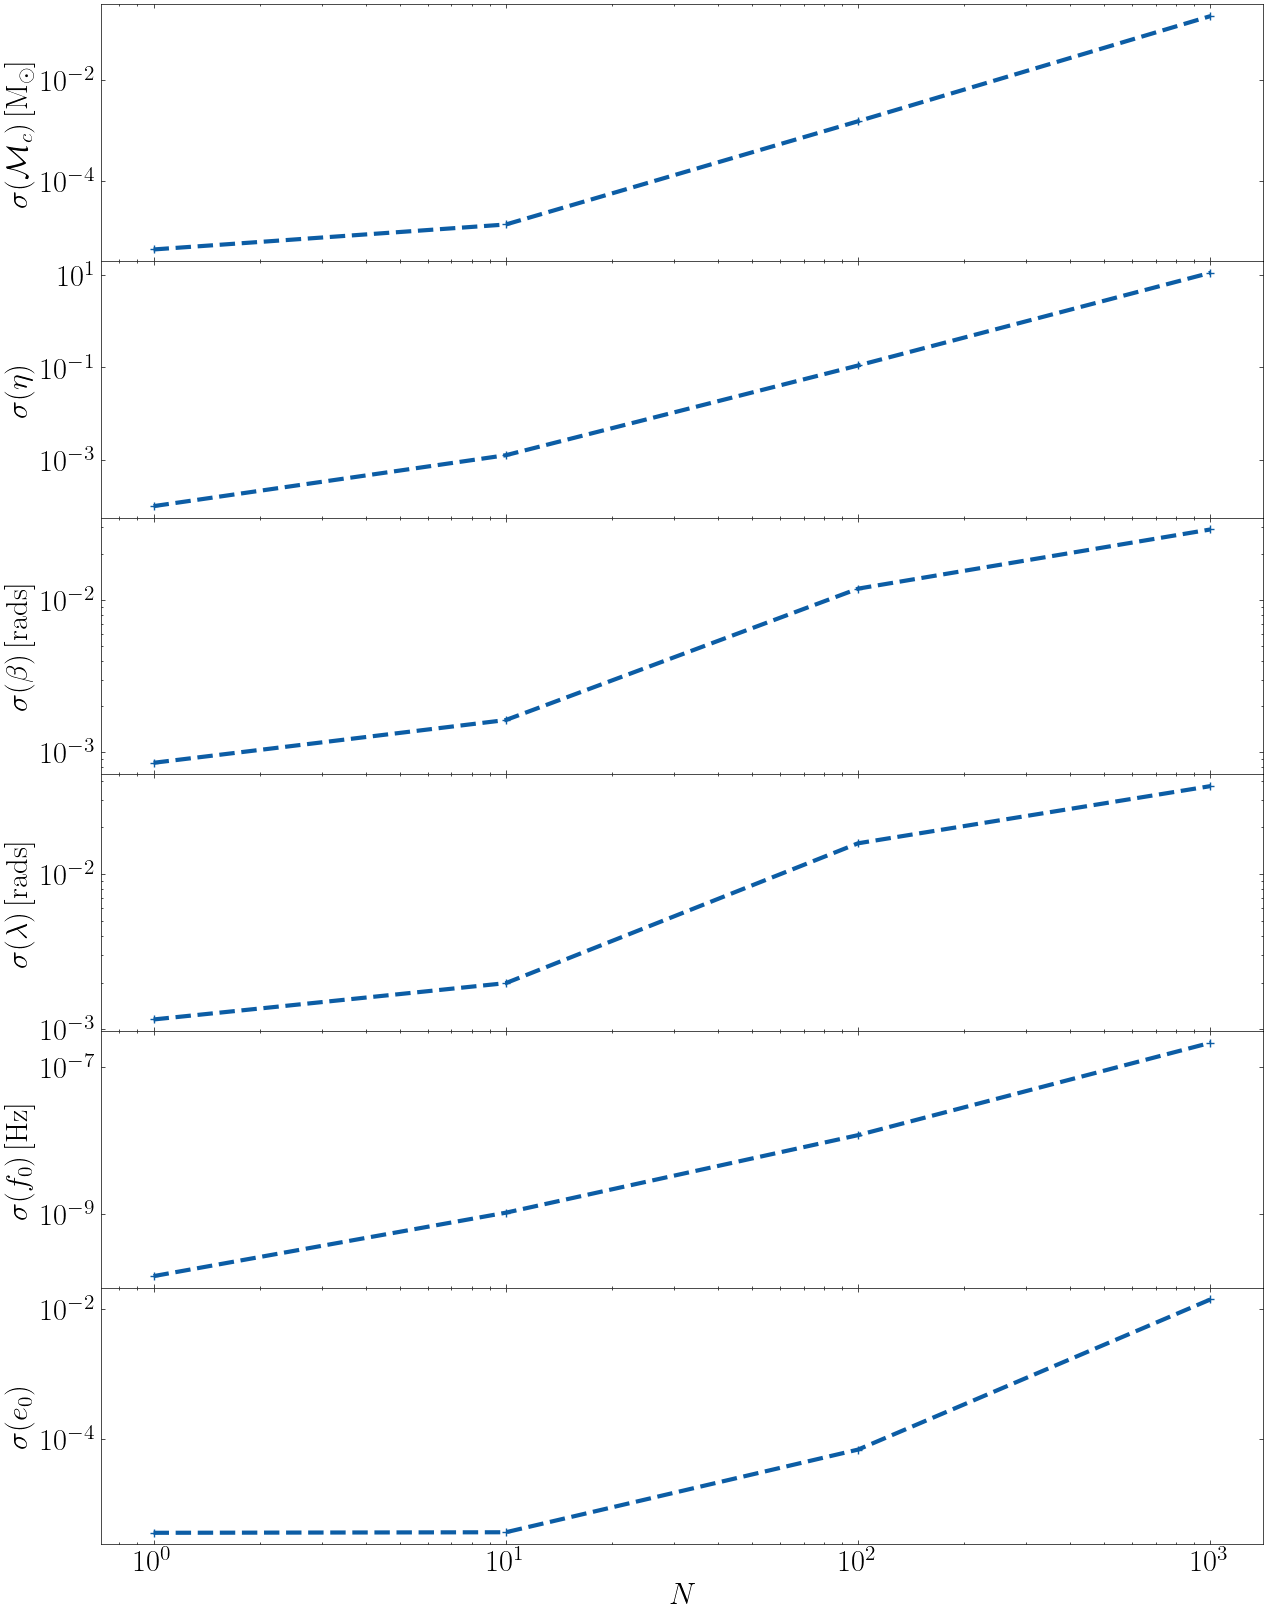

In [54]:
fig, axs = plt.subplots(figsize=(15,20),nrows=6, sharex=True)
for i in range(phasing_param_indexes.size):
    axs[i].loglog(N,[widths_1[i],
                widths_10[i],
                widths_100[i],
                widths_1000[i]],marker='+',lw=3,ls='--')
    axs[i].set_ylabel(labels[i])
plt.subplots_adjust(hspace=0.0)
axs[-1].set_xlabel(r'$N$')
plt.savefig('Match_widths.pdf')
plt.show()

Coherent match

In [2]:
# def waveform_generation(parameters):
#     '''
#     Generate a waveform 
#     '''
#     params_transformed = SC_search.Utility.TaylorF2Ecc_mc_eta_to_m1m2(parameters.copy())
#     wf = SC_search.Waveforms.TaylorF2Ecc.BBHx_response_interpolate_CPU(params_transformed,
#                                                                                   freqs_sparse,
#                                                                                   freqs,
#                                                                                   f_high,
#                                                                                   T_obs,
#                                                                                   'AET',
#                                                                                   logging=False)
#     return(wf)
    
# def second_derivative(params,indexes):
#     '''
#     Compute numerical derivatives of the waveforms for computation of the metric on the parameter space wrt the semi-coherent match 
#     '''

#     # If g_ii term
    
#     if indexes[0] == indexes[1]:

#         forward = params.copy()
#         backward = params.copy()
        
#         forward[indexes[0]] += finite_differences.copy()[indexes[0]]
#         backward[indexes[0]] -= finite_differences.copy()[indexes[0]]
        
#         forward_term = SC_search.Semi_Coherent_Functions.coherent_match(waveform_generation(forward.copy()),
#                                                                              waveform_generation(params.copy()),
#                                                                               psd_array,d)
                        
#         backward_term = SC_search.Semi_Coherent_Functions.coherent_match(waveform_generation(backward.copy()),
#                                                                               waveform_generation(params.copy()),
#                                                                               psd_array,d)
                         
#         central_term = 1#SC_search.Semi_Coherent_Functions.coherent_match(waveform_generation(params.copy()),
#                         #                                                          waveform_generation(params.copy()),
#                         #                                                          psd_array,d)  
        
        
#         der = (forward_term+backward_term-2*central_term)/np.abs(finite_differences.copy()[indexes[0]])**2
        
#     else:
#     # If g_ij
#         forward_i_j = params.copy()
#         backward_i_j = params.copy()
#         forward_i = params.copy()
#         forward_j = params.copy()
#         backward_i = params.copy()
#         backward_j = params.copy()

        
#         forward_i_j[indexes] += finite_differences.copy()[indexes]
#         backward_i_j[indexes] -= finite_differences.copy()[indexes]

#         forward_i[indexes[0]] += finite_differences.copy()[indexes[0]]
#         forward_j[indexes[1]] += finite_differences.copy()[indexes[1]]

#         backward_i[indexes[0]] -= finite_differences.copy()[indexes[0]]
#         backward_j[indexes[1]] -= finite_differences.copy()[indexes[1]]
#         print(backward_i[indexes[0]],backward_j[indexes[1]])
#         forward_ij_term = SC_search.Semi_Coherent_Functions.coherent_match(waveform_generation(forward_i_j.copy()),
#                                                                                   waveform_generation(params.copy()),                                                                                  
#                                                                                   psd_array,d)
                           
#         backward_ij_term = SC_search.Semi_Coherent_Functions.coherent_match(waveform_generation(backward_i_j.copy()),
#                                                                                   waveform_generation(params.copy()), 
#                                                                                   psd_array,d)

#         forward_i_term = SC_search.Semi_Coherent_Functions.coherent_match(waveform_generation(forward_i.copy()),
#                                                                                   waveform_generation(params.copy()),
#                                                                                   psd_array,d)                            

#         forward_j_term = SC_search.Semi_Coherent_Functions.coherent_match(waveform_generation(forward_j.copy()),
#                                                                                   waveform_generation(params.copy()),
#                                                                                   psd_array,d)     
                          
#         backward_i_term = SC_search.Semi_Coherent_Functions.coherent_match(waveform_generation(backward_i.copy()),
#                                                                                   waveform_generation(params.copy()),
#                                                                                   psd_array,d)                            

#         backward_j_term = SC_search.Semi_Coherent_Functions.coherent_match(waveform_generation(backward_j.copy()),
#                                                                                   waveform_generation(params.copy()),
#                                                                                   psd_array,d)                            
        
#         central_term = 1#SC_search.Semi_Coherent_Functions.coherent_match(waveform_generation(params.copy()),
#                         #                                                          waveform_generation(params.copy()),
#                         #                                                          psd_array,d)  
        
#         der = 1/(2*np.abs(finite_differences.copy()[indexes[0]])*np.abs(finite_differences.copy()[indexes[1]]))*(forward_ij_term
#                                                                                                  -forward_i_term
#                                                                                                  -forward_j_term
#                                                                                                  +2*central_term
#                                                                                                  -backward_i_term
#                                                                                                  -backward_j_term
#                                                                                                  +backward_ij_term)
        
#     return(der)
    
# def generate_metric(params):
#     '''
#     Generate metric over all the phasing parameter. Put zeros in the spots for the other parameters.
#     '''

#     # Empty metric array
#     g_ij = np.zeros((params.size,params.size))
    
#     for i in phasing_param_indexes:
#         for j in phasing_param_indexes:
#             index_pairs = (i,j)
#             g_ij[index_pairs] = -1/2*second_derivative(params.copy(),np.array(index_pairs))
    
#     return(g_ij)

# def subset_metric(g_ij_whole):
#     '''
#     Postprocess the metric down to just the phasing parameters. 
#     '''
    
#     g_ij_subset = np.zeros((phasing_param_indexes.size,phasing_param_indexes.size))
    
#     for subset_index_i,i in enumerate(phasing_param_indexes):
#         for subset_index_j,j in enumerate(phasing_param_indexes):
#             g_ij_subset[subset_index_i,subset_index_j] = g_ij_whole[i,j]
            
#     return(g_ij_subset)

In [3]:
# SNR_squared = 4*np.real(np.sum(injection_signal*injection_signal.conj()/psd_array*d))
# SNR = np.sqrt(SNR_squared)
# SNR

In [4]:
# g_1 = subset_metric(generate_metric(source_parameters))


In [5]:
# source_parameters = np.array([28.09555579546043,#mc [sm]
#                     0.24710059171597634,#eta
#                     50.1*(1.e+6),#D
#                     np.pi/4,#beta [rads]
#                     2.01,#lambda [rads]
#                     2.498091544796509,#inc [rads]
#                     -1.851592653589793,#polarization [rads]
#                     0,#phi0 [rads]
#                     0.018/2,
#                     0.01])#e0

In [6]:
# print(np.sqrt(np.diag(np.linalg.inv(g_1)/(2*SNR**2))))
